In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class Scen_gen():
    def __init__(self, spot, drift, vol):
        self.spot = spot
        self.drift = drift
        self.vol = vol
        
    #def LV(self, s, t):               
    
    def MC(self, sims, timesteps, dt):
        x = np.zeros((sims, timesteps + 1))
        for i in range(sims):
            for j in range(timesteps + 1):
                z1 = np.random.normal(0, 1)
                if j == 0:
                    x[i, j] = self.spot  
                else:
                    x[i, j] = x[i, j - 1] * np.exp((self.drift - 0.5 * self.vol ** 2) * dt + (self.vol * dt ** 0.5 * z1))
        return x

In [3]:
class EuroOptionPricer():
    def __init__(self, spot, strike, maturity, drift):
        self.spot = spot
        self.strike = strike
        self.maturity = maturity
        self.drift = drift
    
    def european_call_price(self, scenarios):
        # Calculate the payoff for each scenario at maturity
        call_payoffs = np.maximum(scenarios[:, -1] - self.strike, 0)
        
        # Calculate the option price as the expected value of the payoffs
        option_price = np.mean(call_payoffs) * np.exp(-self.maturity * self.drift)
        
        return option_price

    def european_put_price(self, scenarios):
        # Calculate the payoff for each scenario at maturity
        put_payoffs = np.maximum(self.strike - scenarios[:, -1], 0)
        
        # Calculate the option price as the expected value of the payoffs
        option_price = np.mean(put_payoffs) * np.exp(-self.maturity * self.drift)
        
        return option_price

# Example usage
spot_price = 100
strike_price = 80
time_to_maturity = 10
drift = 0
vol = 0.2


# Create an instance of Scen_gen to generate scenarios
scenario_generator = Scen_gen(spot_price, drift, vol)

# Generate Monte Carlo scenarios
num_simulations = 10000
num_time_steps = 5
time_step_size = time_to_maturity / num_time_steps
scenarios = scenario_generator.MC(num_simulations, num_time_steps, time_step_size)
#print(scenarios)

# Create an instance of OptionPricer to price the option
option_pricer = EuroOptionPricer(spot_price, strike_price, time_to_maturity, drift)

# Calculate the European call and put option prices
call_option_price = option_pricer.european_call_price(scenarios)
put_option_price = option_pricer.european_put_price(scenarios)

print(f"Theoretical European Call Option Price: {call_option_price:.2f}")
print(f"Theoretical European Put Option Price: {put_option_price:.2f}")


Theoretical European Call Option Price: 33.63
Theoretical European Put Option Price: 13.54


In [4]:
#Black Scholes Sanity Check 

def black_scholes(S, K, T, r, sigma, option_type='call'):

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        option_price = S * N_d1 - K * np.exp(-r * T) * N_d2
    elif option_type == 'put':
        N_d1 = norm.cdf(-d1)
        N_d2 = norm.cdf(-d2)
        option_price = K * np.exp(-r * T) * N_d2 - S * N_d1
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price


S = spot_price
K = strike_price
T = time_to_maturity
r = drift
sigma = vol

call_option_price = black_scholes(S, K, T, r, sigma, option_type='call')
put_option_price = black_scholes(S, K, T, r, sigma, option_type='put')

print(f"Theoretical Call Option Price: {call_option_price:.2f}")
print(f"Theoretical Put Option Price: {put_option_price:.2f}")

Theoretical Call Option Price: 33.66
Theoretical Put Option Price: 13.66


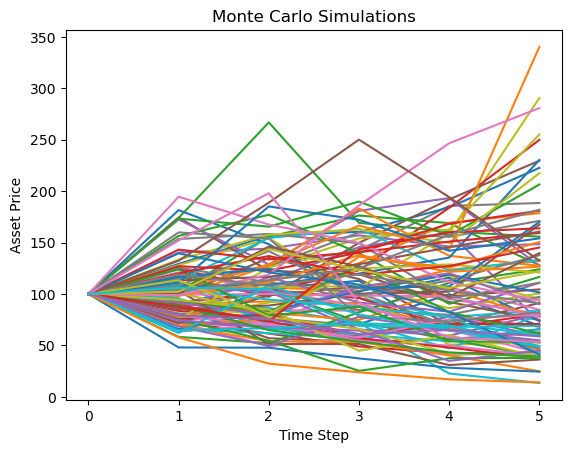

In [5]:
#plots 

for i in range(100):
    plt.plot(scenarios[i])
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Monte Carlo Simulations')
plt.show()


Implied volatility grid has been written to 'implied_volatility_grid.txt'.


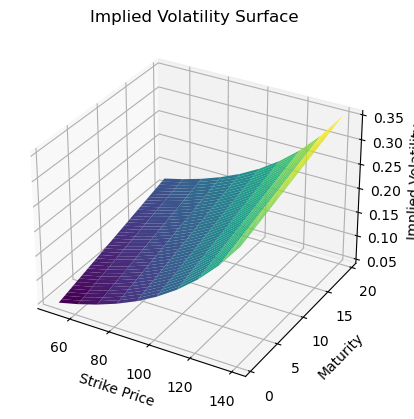

In [6]:
strikes = np.arange(50, 150, 10)
maturities = np.arange(0.5, 20, 0.5)

grid = np.zeros((len(strikes), len(maturities)))

def implied_volatility_smile(strike, maturity):
    a = 0.5  # Parameter controlling the smile shape
    b = 0.02  # Parameter controlling the smile shift
    c = 0.6  # Parameter controlling the slope of volatility with maturity
    return (a * np.exp(b * strike) + 0.2 * (c * maturity))/30

for i in range(len(strikes)):
    for j in range(len(maturities)):
        implied_volatility = implied_volatility_smile(strikes[i], maturities[j])
        grid[i,j] = implied_volatility 
        
#print(grid)

filename = "implied_volatility_grid.txt"

with open(filename, "w") as file:
    file.write("\t" + "\t".join(map(str, maturities)) + "\n")
    for i in range(len(strikes)):
        file.write(str(strikes[i]) + "\t" + "\t".join(map(str, grid[i])) + "\n")

print(f"Implied volatility grid has been written to '{filename}'.")

strike_grid, maturity_grid = np.meshgrid(strikes, maturities)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(strike_grid, maturity_grid, grid.T, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')
plt.show()

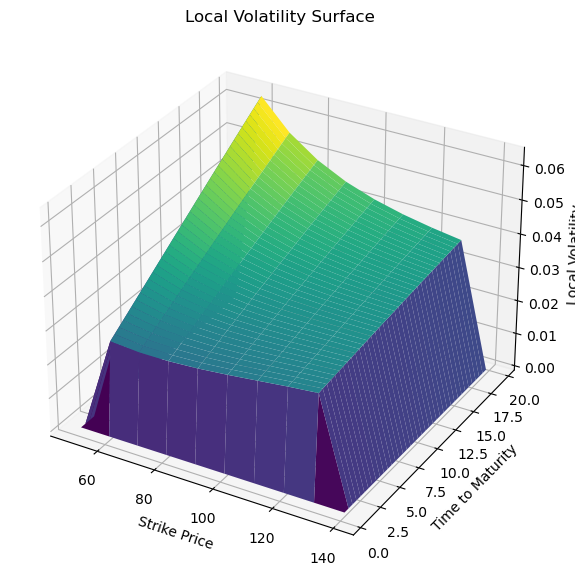

In [37]:
#dupire local vol - basic - not log strike 

from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

strikes = np.arange(50, 150, 10)
maturities = np.arange(0.5, 20, 0.5)
r = 0.03

def implied_volatility_smile(strike, maturity):
    a = 0.5  # Parameter controlling the smile shape
    b = 0.02  # Parameter controlling the smile shift
    c = 0.6  # Parameter controlling the slope of volatility with maturity
    return (a * np.exp(b * strike) + 0.2 * (c * maturity))/30

IV = np.zeros((len(strikes), len(maturities)))

for i in range(len(strikes)):
    for j in range(len(maturities)):
        IV[i, j] = implied_volatility_smile(strikes[i], maturities[j])

local_volatility = np.zeros_like(IV)

for i in range(1, len(maturities)):
    for j in range(1, len(strikes) - 1):
        dt = maturities[i] - maturities[i - 1]
        dK = strikes[j + 1] - strikes[j - 1]

        dIV_dt = (IV[j, i] - IV[j, i - 1]) / dt
        dIV_dK = (IV[j + 1, i] - IV[j - 1, i]) / (2 * dK)
        d2IV_dK2 = (IV[j + 1, i] - 2 * IV[j, i] + IV[j - 1, i]) / (dK ** 2)

        d1 = (np.log(strikes[j]/strikes[j]) + (r + 0.5 * IV[j, i] ** 2) * maturities[i]) / (IV[j, i] * np.sqrt(maturities[i]))

        numerator = dIV_dt + r * strikes[j] * dIV_dK + r * IV[j, i]
        denominator = 0.5 * strikes[j] ** 2 * (d2IV_dK2 + d1 * dIV_dK / (IV[j, i] * np.sqrt(maturities[i])))
        
        local_volatility[j, i] = np.sqrt(numerator / denominator)

X, T = np.meshgrid(strikes, maturities)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, local_volatility.T, cmap='viridis')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Local Volatility')
ax.set_title('Local Volatility Surface')

plt.show()




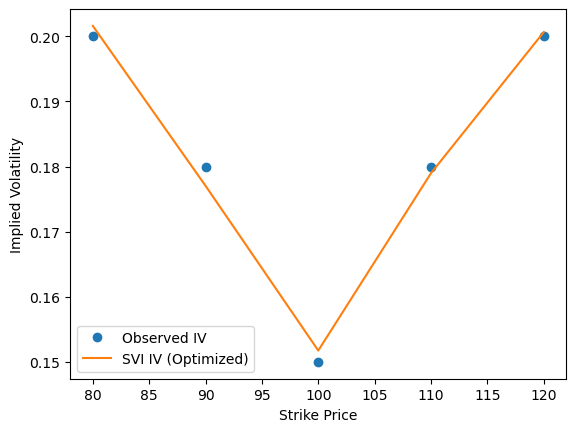

In [32]:
#gatheral SVI - paramatization of 

# Example market data: Strike prices and corresponding observed implied volatilities
strike_prices = np.array([80, 90, 100, 110, 120])
observed_iv = np.array([0.2, 0.18, 0.15, 0.18, 0.2])

# Forward price
F = 100

# Define the SVI model
def svi_volatility(k, a, b, rho, m, sigma):
    return np.sqrt(a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2)))

# Objective function to minimize
def objective(params):
    a, b, rho, m, sigma = params
    model_iv = svi_volatility(np.log(strike_prices / F), a, b, rho, m, sigma)
    return np.sum((model_iv - observed_iv)**2)

# Initial guess for the parameters
initial_params = [0.04, 0.1, -0.4, 0.0, 0.1]

# Boundaries and constraints for the parameters
bounds = [(0, None), (0, None), (-1, 1), (None, None), (0, None)]

# Optimize the parameters
result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')

# Extract the optimized parameters
a_opt, b_opt, rho_opt, m_opt, sigma_opt = result.x

# Calculate the SVI implied volatility using the optimized parameters
k = np.log(strike_prices / F)
optimized_iv = svi_volatility(k, a_opt, b_opt, rho_opt, m_opt, sigma_opt)

# Plot the observed and SVI implied volatilities
plt.plot(strike_prices, observed_iv, 'o', label='Observed IV')
plt.plot(strike_prices, optimized_iv, label='SVI IV (Optimized)')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()
